# CAB420 A2 Generator Example

### Semantic Class Labels:
- 0 - Sky
- 1 - Tree
- 2 - Road
- 3 - Grass
- 4 - Water
- 5 - Building
- 6 - Mountain
- 7 - Foreground Object

Dataset Link: http://dags.stanford.edu/projects/scenedataset.html

Imports needed for this code to work.

In [1]:
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from matplotlib import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation

Configurable parameters. Change the directories to those for your system.

In [2]:
# Constants.
SEED = 1                 # Seed for consistent randomness
BATCH_SIZE = 50          # Training batch size
NUM_CLASSES = 8          # Number of classes present in the data (see above for types)
IMAGE_SIZE = 128         # Desired size of images
NUM_EPOCHS = 40

# Directories to load data from.
images_directory = "Data/images/"
labels_directory = "Data/labels/"

Defining functions to load data.

In [3]:
def load_images(directory):
    filenames = os.listdir(directory)
    filenames.sort()
    image_filenames = [name for name in filenames if name.endswith('.jpg')]
    num_images = len(image_filenames)
    
    images = []
    for i, filename in enumerate(image_filenames):
        filename = image_filenames[i]
        img = image.imread(directory + filename) / 255
        images.append(img)
        
    return images


def load_labels(directory):
    filenames = os.listdir(directory)
    filenames.sort()
    label_filenames = [name for name in filenames if name.endswith('regions.txt')]
    num_labels = len(label_filenames)
    
    labels = []
    for i, filename in enumerate(label_filenames):
        filename = label_filenames[i]
        label = np.genfromtxt(directory + filename, delimiter=' ')
        label = label.reshape((label.shape[0], label.shape[1], 1))
        labels.append(label)
    
    return labels

def min_image_size(images):
    min_height = np.inf
    min_width = np.inf
    for image in images:
        height = image.shape[0]
        width = image.shape[1]
        min_height = min(height, min_height)
        min_width = min(width, min_width)
        
    return min_height, min_width 

Loading the data, and splitting it into training and testing sets.

In [4]:
images = load_images(images_directory)
labels = load_labels(labels_directory)

train_threshold = round(len(images) * 0.75)
train_images = images[:train_threshold]
test_images = images[train_threshold:]
train_labels = labels[:train_threshold]
test_labels = labels[train_threshold:]

min_image_dims = min_image_size(images)

print("Total samples (images, labels):", len(images), len(labels))
print("Training samples (images, labels):", len(train_images), len(train_labels))
print("Testing samples (images, labels):", len(test_images), len(test_labels))
print("Min image dimensions:", min_image_dims)

Total samples (images, labels): 715 715
Training samples (images, labels): 536 536
Testing samples (images, labels): 179 179
Min image dimensions: (137, 213)


Plotting some examples to make sure data loading is working properly.

Image shape: (240, 320, 3)
Label shape: (240, 320, 1)


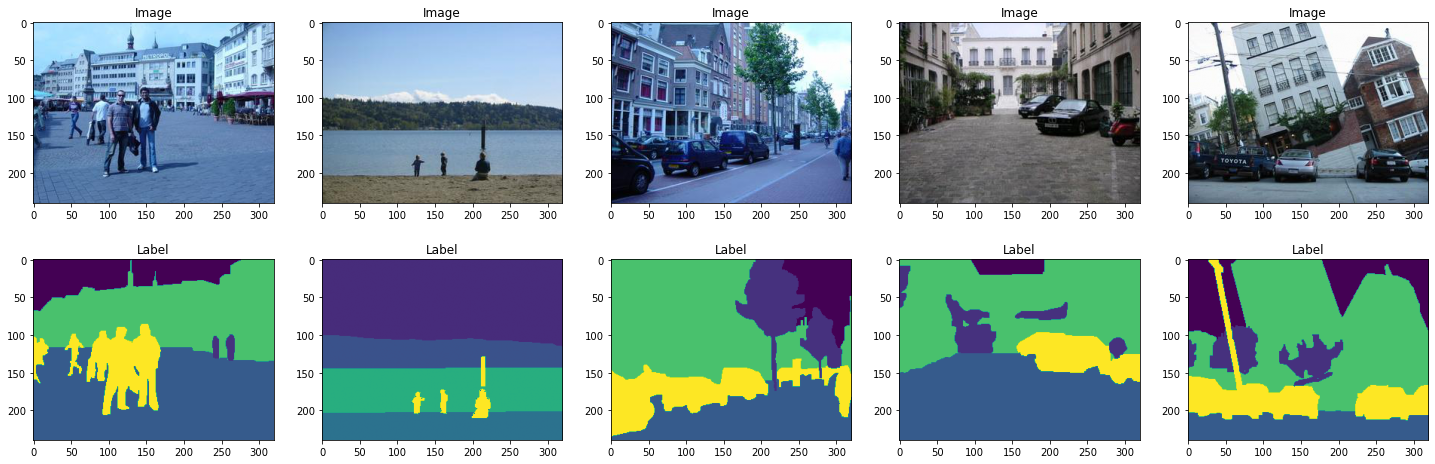

In [5]:
print("Image shape:", images[0].shape)
print("Label shape:", labels[0].shape)

fig = plt.figure(figsize=[25, 8])
for i in range(5):   
    axes = fig.add_subplot(2, 5, i + 1)
    axes.imshow(images[i])
    axes.set_title("Image")
for i in range(5):   
    axes = fig.add_subplot(2, 5, 6 + i)
    axes.imshow(labels[i])
    axes.set_title("Label")

Defining the generator.

In [6]:
# Converts the input label image to one hot vector representation.
def label_to_onehot(image, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(image, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

# Converts the input label in one hot vector representation back to an image.
def onehot_to_label(image):
    mask = tf.dtypes.cast(tf.argmax(image, axis=2), 'uint8')
    return mask

# Applies random cropping to the input image and label to the specified dimensions.
def random_crop(img, label, crop_size):
    height, width = img.shape[0], img.shape[1]
    dy, dx = crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :], label[y:(y+dy), x:(x+dx), :]

# Applies random flipping to the input image and label with 50% probability.
def random_flip_horizontal(img, label):
    do_flip = np.random.random()
    if do_flip < 0.5:
        return np.fliplr(img), np.fliplr(label)
    else:
        return img, label

# Gets a random subset of the input lists.
def random_subset(images, labels, subset_size):
    subset_indices = np.random.randint(0, len(images), subset_size)
    # Make sure there are no repeating indices
    while len(subset_indices) < len(np.unique(subset_indices)):
        subset_indices = np.random.randint(0, len(images), subset_size)
    
    subset_images = [images[i] for i in subset_indices]
    subset_labels = [labels[i] for i in subset_indices]
    return subset_images, subset_labels

# The data generator.
def CroppedImageGenerator(images, labels, batch_size, image_size, num_classes, seed=None):
    assert batch_size <= len(images)
    # Set the random seed.
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    
    # Define the generator.
    while True:
        # Get a random batch of images.
        batch_images, batch_labels = random_subset(images, labels, batch_size)
        
        # Apply random cropping to the specified size and random horizontal flipping.
        cropped_images = np.zeros((batch_size, image_size, image_size, 3))
        cropped_labels = np.zeros((batch_size, image_size, image_size, 1))
        for i in range(batch_size):
            cropped_image, cropped_label = random_crop(batch_images[i], batch_labels[i], (image_size, image_size))
            cropped_images[i], cropped_labels[i] = random_flip_horizontal(cropped_image, cropped_label)
        
        # Convert our labels to one hot vector form.
        cropped_labels = label_to_onehot(cropped_labels, num_classes)
        
        # Yeild one generator output.
        yield (cropped_images, cropped_labels)

Getting one batch from the generator.

Image shape: (128, 128, 3)
Label shape: (128, 128, 8)


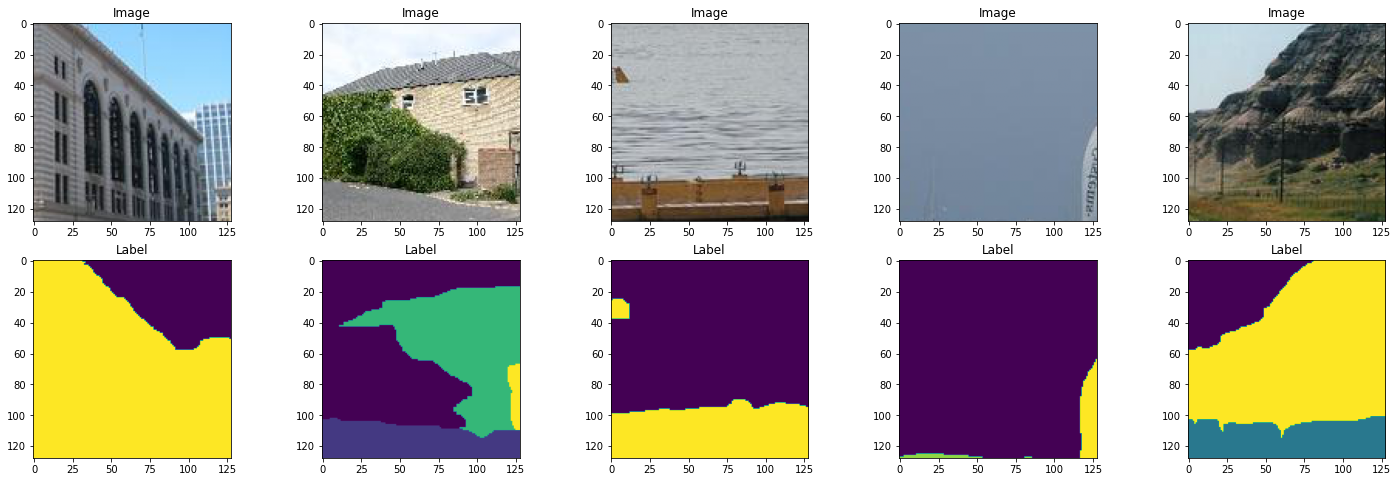

In [7]:
data_generator = CroppedImageGenerator(images, labels, BATCH_SIZE, IMAGE_SIZE, NUM_CLASSES, seed=SEED)
batch_images, batch_labels = next(data_generator)

print("Image shape:", batch_images[0].shape)
print("Label shape:", batch_labels[0].shape)

fig = plt.figure(figsize=[25, 8])
for i in range(5):   
    axes = fig.add_subplot(2, 5, i + 1)
    axes.imshow(batch_images[i])
    axes.set_title("Image")
for i in range(5):
    axes = fig.add_subplot(2, 5, 6 + i)
    axes.imshow(onehot_to_label(batch_labels[i]))
    axes.set_title("Label")

## Feeding Generator Input to Week 10 Semantic Segmentation Example

Defining the semantic segmentation model.

In [8]:
def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output), axis=-1)

input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
conv1 = Conv2D(16, (3, 3), activation=None, padding='same')(conv1)
conv1 = SpatialDropout2D(0.2)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
conv2 = SpatialDropout2D(0.2)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
conv3 = SpatialDropout2D(0.2)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation=None, padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = SpatialDropout2D(0.2)(conv4)
conv4 = Activation('relu')(conv4)

up1 = UpSampling2D((2, 2))(conv4)
merge1 = concatenate([conv3,up1], axis = 3)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
conv5 = SpatialDropout2D(0.2)(conv5)
conv5 = Activation('relu')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
merge2 = concatenate([conv2,up2], axis = 3)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
conv6 = SpatialDropout2D(0.2)(conv6)
conv6 = Activation('relu')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
merge3 = concatenate([conv1,up3], axis = 3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
conv7 = SpatialDropout2D(0.2)(conv7)
conv7 = Activation('relu')(conv7)

decoded = Conv2D(NUM_CLASSES, (1, 1), activation='softmax', padding='same')(conv7)

segmenter = Model(input_img, decoded)
segmenter.compile(optimizer='adam', loss=focal_loss)
print(segmenter.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Train the model.

In [9]:
train_generator = CroppedImageGenerator(train_images, train_labels, BATCH_SIZE, IMAGE_SIZE, NUM_CLASSES, seed=SEED)
test_generator = CroppedImageGenerator(test_images, test_labels, BATCH_SIZE, IMAGE_SIZE, NUM_CLASSES, seed=SEED)

history = segmenter.fit(train_generator, steps_per_epoch=(len(train_images) // BATCH_SIZE + 1), epochs=NUM_EPOCHS,
                        validation_data=test_generator, validation_steps=10)

Epoch 1/40
11/11 [==============================] - 38s 3s/step - loss: 1.3641 - val_loss: 1.3030
Epoch 2/40
11/11 [==============================] - 35s 3s/step - loss: 1.2656 - val_loss: 1.2484
Epoch 3/40
11/11 [==============================] - 35s 3s/step - loss: 1.2156 - val_loss: 1.1873
Epoch 4/40
11/11 [==============================] - 35s 3s/step - loss: 1.2482 - val_loss: 1.1125
Epoch 5/40
11/11 [==============================] - 35s 3s/step - loss: 1.1759 - val_loss: 1.1792
Epoch 6/40
11/11 [==============================] - 35s 3s/step - loss: 1.1454 - val_loss: 1.0915
Epoch 7/40
11/11 [==============================] - 35s 3s/step - loss: 1.1133 - val_loss: 1.0076
Epoch 8/40
11/11 [==============================] - 35s 3s/step - loss: 1.0966 - val_loss: 1.0123
Epoch 9/40
11/11 [==============================] - 35s 3s/step - loss: 1.0840 - val_loss: 0.9725
Epoch 10/40
11/11 [==============================] - 35s 3s/step - loss: 1.1216 - val_loss: 1.0187
Epoch 11/40
11/11 [

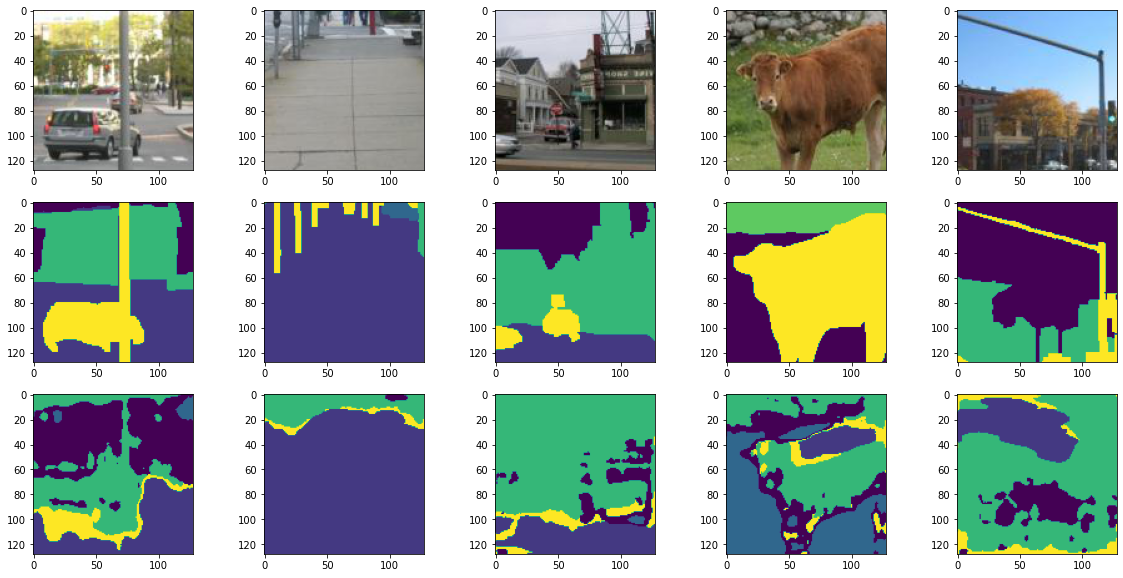

In [12]:
def visualise(model, images, labels):
    pred = model.predict(images)
    
    fig = plt.figure(figsize=[20, 10])
    
    for i in range(5):
        axes = fig.add_subplot(3, 5, i + 1)
        axes.imshow(images[i])
        axes = fig.add_subplot(3, 5, i + 6)
        axes.imshow(onehot_to_label(labels[i,:,:,:]))
        axes = fig.add_subplot(3, 5, i + 11)
        axes.imshow(onehot_to_label(pred[i,:,:,:]))

vis_images, vis_labels = next(train_generator)
visualise(segmenter, vis_images, vis_labels)

Plotting training and validation loss vs epoch.

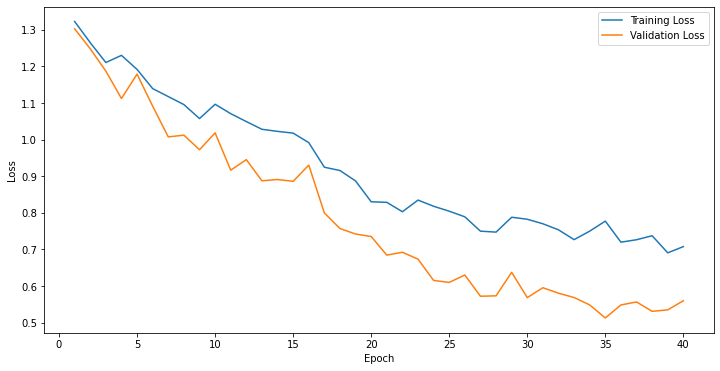

In [11]:
fig = plt.figure(figsize=[12, 6])
axes = fig.add_subplot(1, 1, 1)
epoch_axis = np.arange(NUM_EPOCHS) + 1
axes.plot(epoch_axis, history.history['loss'], label="Training Loss")
axes.plot(epoch_axis, history.history['val_loss'], label="Validation Loss")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend()